This script takes a date (year, month, day), travel direction (Westbound or Eastbound), and traffic site (siteid) as input and outputs a figure showing historical traffic data for that month and day of year. 

Laura Kehrl, 19 Feb 2018

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats

# Input data for app
year = 2019
month = 'August'
day = 18
direction = 'Eastbound'
siteid = 'S901'

In [2]:
# Traffic sites
I90_sites = ['S901','R039W','S903','B04']
SR2_sites = ['R038','R058E','R047WW']
road_sites = I90_sites+SR2_sites

# Get data for all sites
road_vehicle, road_speed, road_count = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for site in road_sites:
    road_vehicle = road_vehicle.append(pd.read_csv('traffic_data/'+\
            'TrafficVolumeByVehicleTypeAndHour_'+site+'_2007-01_2017-12.csv'))
    road_speed = road_speed.append(pd.read_csv('traffic_data/TrafficSpeedByHour_'+site+\
            '_2007-01_2017-12.csv'))
    road_count = road_count.append(pd.read_csv('traffic_data/TrafficVolumeByHour_'+site+\
            '_2007-01_2017-12.csv'))

In [3]:
# Add columns for datetime, day of year, weekend, weeknum, and month
for frame in [road_vehicle, road_speed, road_count]:
    frame['datetime'] = pd.to_datetime(frame.Date)
    frame['DOY'] = frame['datetime'].apply(lambda x: x.timetuple().tm_yday)
    # Define weekend as Saturday/Sunday
    frame['Weekend'] = frame['datetime'].apply(lambda x: x.dayofweek > 4).astype(float)
    frame['WeekNum'] = frame['datetime'].apply(lambda x: int(x.strftime("%U")))
    frame['Month'] = frame['datetime'].apply(lambda x: x.strftime("%B"))

In [4]:
# Calculate average speed

# First, get daily counts according to speed files
road_speed['DailyCount'] = 0
for key in road_speed.keys():
    if key.startswith('TrafficVolCnt'):
        road_speed['DailyCount'] = road_speed['DailyCount']+road_speed[key]

# Then calculate the average speed 
road_speed['AverageMPH'] = 0
for key in road_speed.keys():
    if key.startswith('TrafficVolCnt'):
        if key == 'TrafficVolCntOver0To5MPH':
            avespeed = 2.5
        elif key == 'TrafficVolCntOver5To10MPH':
            avespeed = 7.5
        else:
            avespeed = (np.float(key[-9:-7])+np.float(key[-5:-3]))/2.
        road_speed['AverageMPH'] = road_speed['AverageMPH']+\
                avespeed*road_speed[key].astype(float)

# Get interquartile range
road_speed['Quartile25'] = 0
road_speed['Quartile75'] = 0
temp = pd.Series(road_speed['datetime'])
temp['Count'] = 0
for key in road_speed.keys():
    if key.startswith('TrafficVolCnt'):
        if key == 'TrafficVolCntOver0To5MPH':
            avespeed = 2.5
        elif key == 'TrafficVolCntOver5To10MPH':
            avespeed = 7.5
        else:
            avespeed = (np.float(key[-9:-7])+np.float(key[-5:-3]))/2.
        road_speed.loc[temp['Count'] <= (road_speed['DailyCount']*0.25),'Quartile25'] = avespeed
        road_speed.loc[temp['Count'] <= (road_speed['DailyCount']*0.75),'Quartile75'] = avespeed
        temp['Count'] = temp['Count']+road_speed[key]

road_speed['AverageMPH'] = road_speed['AverageMPH']/road_speed['DailyCount']
del temp

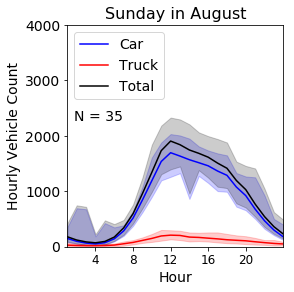

In [5]:
# Get historical data for that month and day of week

date = dt.datetime.strptime(str(day)+' '+month+' '+str(year),'%d %B %Y')

dow = calendar.day_name[date.weekday()]
weeknum = int(date.strftime("%U"))
month = date.strftime("%B")

road_speed_week = road_speed[(road_speed['TravelDirection'] == direction) &\
        (road_speed['SiteId'] == siteid)].groupby(['Month','DayOfWeek'])
road_vehicle_week = road_vehicle[(road_vehicle['TravelDirection'] == direction) &\
        (road_vehicle['SiteId'] == siteid)].groupby(['Month','DayOfWeek','VehicleType'])

n = 0
hourly_totals = np.zeros([len(road_vehicle['VehicleType'].unique()),24,4])
for vehtype in road_vehicle['VehicleType'].unique():
    group = road_vehicle_week.get_group((month,dow,vehtype))
    
    for i in range(0,24):
        hourly_totals[n,i,0] = group['Hour'+str(i+1)].mean()
        hourly_totals[n,i,1] = group['Hour'+str(i+1)].max()
        hourly_totals[n,i,2] = group['Hour'+str(i+1)].min()
        hourly_totals[n,i,3] = group['Hour'+str(i+1)].count()
    n += 1 
        
hourly_speeds = np.zeros([24,4])
group = road_speed_week.get_group((month,dow))
for i in range(0,24):
    hourly_speeds[i,0] = group.loc[group['Hour']==i+1,'AverageMPH'].mean()  
    hourly_speeds[i,1] = group.loc[group['Hour']==i+1,'AverageMPH'].max() 
    hourly_speeds[i,2] = group.loc[group['Hour']==i+1,'AverageMPH'].min() 
    hourly_speeds[i,3] = group.loc[group['Hour']==i+1,'AverageMPH'].count() 

fig, (ax1) = plt.subplots(1,1,sharex=True,figsize=(4,4))

ax1.plot(range(1,25),hourly_totals[0,:,0],'b',label='Car')
ax1.fill_between(range(1,25),hourly_totals[0,:,1],\
                 hourly_totals[0,:,2],color='b',alpha=0.2)
ax1.plot(range(1,25),np.sum(hourly_totals[1:,:,0],axis=0),'r',label='Truck')
ax1.fill_between(range(1,25),np.sum(hourly_totals[1:,:,1],axis=0),\
                 np.sum(hourly_totals[1:,:,2],axis=0),color='r',alpha=0.2)
ax1.plot(range(1,25),np.sum(hourly_totals[:,:,0],axis=0),'k',label='Total')
ax1.fill_between(range(1,25),np.sum(hourly_totals[:,:,1],axis=0),\
                 np.sum(hourly_totals[:,:,2],axis=0),color='k',alpha=0.2)
#ax1.set_ylim([0,3500])
ax1.set_xlim([1,24])
ax1.legend(loc=2,fontsize=14)
#ax1.set_xticklabels([])
ax1.set_ylabel('Hourly Vehicle Count',fontsize=14)
ax1.set_title(dow+' in '+str(month),fontsize=16)
plt.xticks(np.arange(4,24,4),fontsize=12)
if siteid in I90_sites:
    plt.ylim([0,4000])
    plt.yticks(np.arange(0,4050,1000),fontsize=14)
elif siteid in SR2_sites:
    plt.ylim([0,1100])
    plt.yticks(np.arange(0,1050,250),fontsize=14)
ymin,ymax = ax1.get_ylim()
ax1.text(1.7,ymin+(ymax-ymin)*0.57,'N = {0:2.0f}'.format(hourly_totals[0,0,3]),fontsize=14)
plt.xlabel('Hour',fontsize=14)

plt.tight_layout()
plt.subplots_adjust(left=0.23,right=0.98,bottom=0.13,top=0.9)
plt.savefig('figures/'+siteid+'_'+direction+'_'+month+'_'+dow+'.pdf')
